# NOTE
This is merely a copy of the "Getting Started" example from the Edward documentation, available at http://nbviewer.jupyter.org/github/blei-lab/edward/blob/master/notebooks/getting_started.ipynb, but reproduced here for simplicity.

# Your first Edward program

Probabilistic modeling in Edward uses a simple language of random variables. Here we will show a Bayesian neural network. It is a neural network with a prior distribution on its weights.

A webpage version is available at 
http://edwardlib.org/getting-started.

In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from edward.models import Normal

plt.style.use('ggplot')

In [2]:
def build_toy_dataset(N=50, noise_std=0.1):
  x = np.linspace(-3, 3, num=N)
  y = np.cos(x) + np.random.normal(0, noise_std, size=N)
  x = x.astype(np.float32).reshape((N, 1))
  y = y.astype(np.float32)
  return x, y


def neural_network(x, W_0, W_1, b_0, b_1):
  h = tf.tanh(tf.matmul(x, W_0) + b_0)
  h = tf.matmul(h, W_1) + b_1
  return tf.reshape(h, [-1])

First, simulate a toy dataset of 50 observations with a cosine relationship.

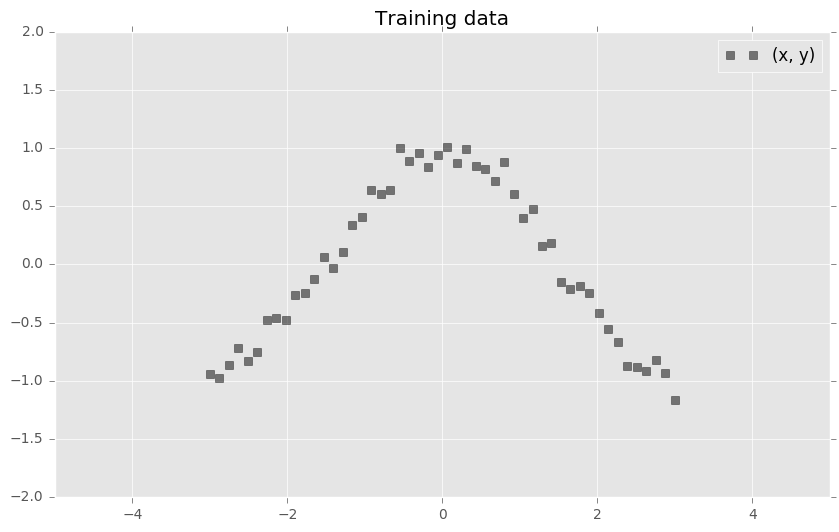

In [4]:
ed.set_seed(42)

N = 50  # number of data ponts
D = 1   # number of features

x_train, y_train = build_toy_dataset(N)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Training data")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

Next, define a two-layer Bayesian neural network. Here, we define the neural network manually with `tanh` nonlinearities.

In [5]:
W_0 = Normal(loc=tf.zeros([D, 2]), scale=tf.ones([D, 2]))
W_1 = Normal(loc=tf.zeros([2, 1]), scale=tf.ones([2, 1]))
b_0 = Normal(loc=tf.zeros(2), scale=tf.ones(2))
b_1 = Normal(loc=tf.zeros(1), scale=tf.ones(1))

x = x_train
y = Normal(loc=neural_network(x, W_0, W_1, b_0, b_1),
           scale=0.1 * tf.ones(N))

Next, make inferences about the model from data. We will use variational inference. Specify a normal approximation over the weights and biases.

In [6]:
qW_0 = Normal(loc=tf.Variable(tf.random_normal([D, 2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([D, 2]))))
qW_1 = Normal(loc=tf.Variable(tf.random_normal([2, 1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2, 1]))))
qb_0 = Normal(loc=tf.Variable(tf.random_normal([2])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))
qb_1 = Normal(loc=tf.Variable(tf.random_normal([1])),
              scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

Defining `tf.Variable` allows the variational factors’ parameters to vary. They are initialized randomly. The standard deviation parameters are constrained to be greater than zero according to a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) transformation.

In [7]:
# Sample functions from variational model to visualize fits.
rs = np.random.RandomState(0)
inputs = np.linspace(-5, 5, num=400, dtype=np.float32)
x = tf.expand_dims(inputs, 1)
mus = tf.stack(
    [neural_network(x, qW_0.sample(), qW_1.sample(),
                    qb_0.sample(), qb_1.sample())
     for _ in range(10)])

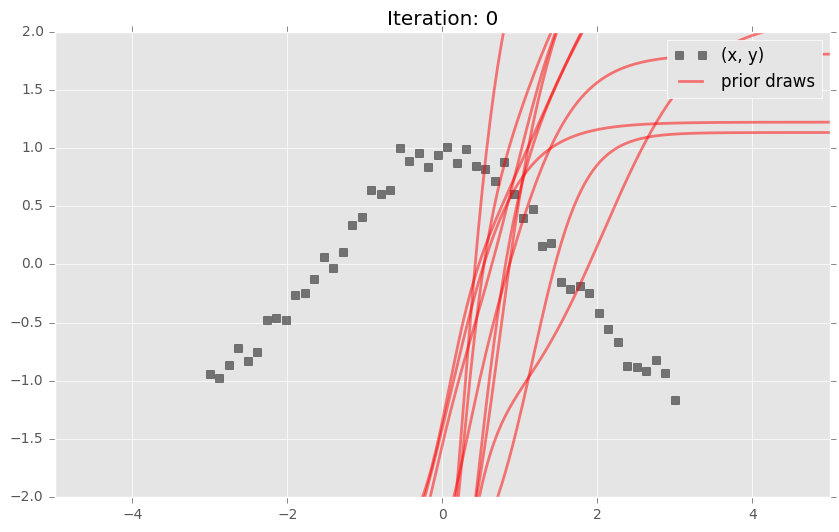

In [8]:
# FIRST VISUALIZATION (prior)

sess = ed.get_session()
tf.global_variables_initializer().run()
outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 0")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='prior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

Now, run variational inference with the [Kullback-Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) divergence in order to infer the model’s latent variables with the given data. We specify `1000` iterations.

In [9]:
inference = ed.KLqp({W_0: qW_0, b_0: qb_0,
                     W_1: qW_1, b_1: qb_1}, data={y: y_train})
inference.run(n_iter=1000, n_samples=5)

1000/1000 [100%] ██████████████████████████████ Elapsed: 7s | Loss: -8.701


Finally, criticize the model fit. Bayesian neural networks define a distribution over neural networks, so we can perform a graphical check. Draw neural networks from the inferred model and visualize how well it fits the data.

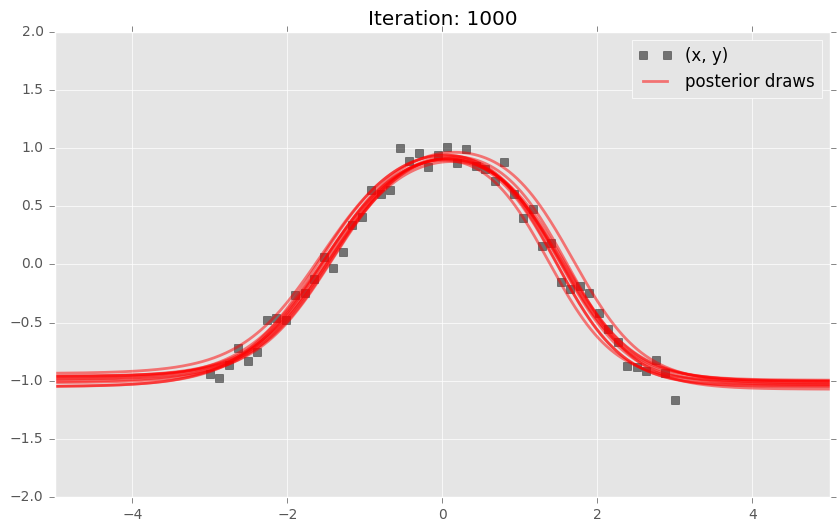

In [10]:
# SECOND VISUALIZATION (posterior)

outputs = mus.eval()

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.set_title("Iteration: 1000")
ax.plot(x_train, y_train, 'ks', alpha=0.5, label='(x, y)')
ax.plot(inputs, outputs[0].T, 'r', lw=2, alpha=0.5, label='posterior draws')
ax.plot(inputs, outputs[1:].T, 'r', lw=2, alpha=0.5)
ax.set_xlim([-5, 5])
ax.set_ylim([-2, 2])
ax.legend()
plt.show()

The model has captured the cosine relationship between $x$ and $y$ in the observed domain.


To learn more about Edward, [delve in](http://edwardlib.org/api)!

If you prefer to learn via examples, then check out some
[tutorials](http://edwardlib.org/tutorials/).